To begin copy this notebook to your own drive:

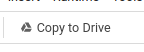


### Submission Instructions:
1. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
2. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and all the cells include their outputs

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [ ]:
!pip install datasets
!pip install transformers
!pip install nltk
!pip install evaluate

In [ ]:
import nltk
nltk.download('punkt_tab')
## If you're usig older version of nltk, you night need to use this lin instead:
# nltk.download('punkt')

In [8]:
# The assignment zip includes 2 files you need to use:
# 'glove.npy' and 'vocab.json'.
# you can upload the directly to this session storage, using the "files" button on the left menu,
# and then the "upload" button on the top of the sidebar. This upload is only valid for each session,
# so if you restart the session you'll neeed to upload the files again

# If you prefer, You can download the files directly to the sessio using these three lines:
# import gdown
# gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
# gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

In [9]:
import numpy as np
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

In [10]:
from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [ ]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

In [12]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [ ]:
from evaluate import load
metric = load("accuracy")

### If you're using older versions, use:
# metric = dataset.load_metric("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [15]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:

  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:

      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]

    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


## SECTION A - DAN implentation

In [16]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self): # YOU ARE ALSO ALLOWED TO ADD PARAMETER TO THE __INIT__
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE

          # END YOUR END



  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE

      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}



In [ ]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments

co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs= , #must be at least 10.
                                  per_device_train_batch_size=,
                                  per_device_eval_batch_size=,
                                  learning_rate= ,
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  eval_strategy="epoch") # Older version might need 'evaluation_strateg' instead
model = DAN()



trainer = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE

                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()

In [ ]:
# You may add Cells & Code lines if you need

## SECTION B - Trying drpout

In [ ]:
# YOUR CODE HERE

## SCETION C - Different Layer num

In [ ]:
# YOUR CODE HERE

## SECTION D - Activations

In [ ]:
# YOUR CODE HERE

## SECRION E - Sample 5 examples

In [ ]:
# YOUR CODE HERE